# Step0: defineProb_statement

**Objective**

To develop a machine learning (DNN) model using a Mulit-layer perceptron (MLP or Multi-Variant) to forecast the closing price of TCS stock for the next 5 days when dataset ended, also plot the trained of close over the whole data based on historical stock price data.




**Step-Taken**


# Step1: Load_Data

In [ ]:
# import req library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Data in format y-m-d

In [27]:
# Load the dataset

file_path = '/content/cleanData_TCS_25Aug2004_5sep2024_NSE.csv'
data = pd.read_csv(file_path)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d') # date format-- year-month-day

## s(i) EDA

EDA = Exploratory data analysis

In [ ]:
# import ydata python library instead of pandas-profiling

# !pip install ydata-profiling

# from ydata_profiling import ProfileReport

# # create profile
# profile = ProfileReport(data)

# # save report
# profile.to_file(output_file='output_TCS.html')

## s(ii) Trail_01_deleteLast_5rows

In [28]:

file_path = '/content/cleanData_TCS_25Aug2004_5sep2024_NSE.csv'

data = pd.read_csv(file_path)
# Display the original dataset
print("Original dataset:")
print(data)

# Remove the last 5 rows
data = data[:-5]

# Display the updated dataset
print("\nUpdated dataset (last 5 rows removed):")
print(data)


Original dataset:
            Date      Open      High       Low     Close       Volume
0     2004-08-25  1,198.70  1,198.70       979    987.95  1,71,16,372
1     2004-08-26       992       997     975.3       979    50,55,400
2     2004-08-27     982.4     982.4    958.55    962.65    38,30,750
3     2004-08-30     969.9       990       965    986.75    30,58,151
4     2004-08-31     986.5       990       976     988.1    26,49,332
...          ...       ...       ...       ...       ...          ...
4962  2024-08-30  4,500.00  4,592.25  4,487.80  4,553.75    36,37,222
4963  2024-09-02  4,576.00  4,588.00  4,512.00  4,521.05    12,16,500
4964  2024-09-03  4,521.05  4,555.90  4,495.90  4,512.35    17,17,263
4965  2024-09-04  4,476.95  4,487.00  4,436.70  4,479.25    12,65,505
4966  2024-09-05  4,481.00  4,499.00  4,454.15  4,475.95    16,88,793

[4967 rows x 6 columns]

Updated dataset (last 5 rows removed):
            Date      Open      High       Low     Close       Volume
0     2

# Step2: Data_PreProcessing

## s(i) assign_Dep_Indep_Variable

In [31]:
# Independent variables (X-axis): 'Open', 'Low', 'High', 'Adj Close', 'Volume'
# Dependent variable (Y-axis): 'Close'


X = data[['Open', 'Low', 'High', 'Volume']].values
Y = data['Close'].values

In [32]:
X

array([[1.1987000e+03, 9.7900000e+02, 1.1987000e+03, 1.7116372e+07],
       [9.9200000e+02, 9.7530000e+02, 9.9700000e+02, 5.0554000e+06],
       [9.8240000e+02, 9.5855000e+02, 9.8240000e+02, 3.8307500e+06],
       ...,
       [4.5050000e+03, 4.4868000e+03, 4.5100000e+03, 9.3069700e+05],
       [4.4987500e+03, 4.4573000e+03, 4.5625000e+03, 1.8480580e+06],
       [4.4600000e+03, 4.4600000e+03, 4.5560000e+03, 2.1336410e+06]])

## s(ii) Normalize_MinMax_Scale

In [33]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Replace commas in numerical columns with empty strings and convert to numeric

for col in ['Open', 'Low', 'High', 'Volume', 'Close']: # Include 'Close' in the loop

    if data[col].dtype == object:
        data[col] = pd.to_numeric(data[col].str.replace(',', ''), errors='coerce')
    else:
      pass



# Now, redefine X and Y using the updated 'data'
X = data[['Open', 'Low', 'High', 'Volume']].values
Y = data['Close'].values


scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1))

In [34]:
# Scale the data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1))

Why 60?

Ans: In summary, look_back = 60 means you are using the previous 60 time steps of data to predict the next time step in your time series prediction task. Adjusting this parameter might affect how your model learns from historical data and predicts future values.



*   The choice of look_back = 60 in our example suggests that we are using 60 previous time steps (or data points) to predict the next data point in our time series.




In [35]:
# Create a function to create sequences for LSTM

def create_sequences(X, Y, time_steps=1):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        Ys.append(Y[i + time_steps])
    return np.array(Xs), np.array(Ys)


time_steps = 60  # Use the past 60 days to predict the next day
X_seq, Y_seq = create_sequences(X_scaled, Y_scaled, time_steps)

## s(iii) split_TrainTest

In [36]:
# Split the data into training and test sets


train_size = int(len(X) * 0.8)  # 80% for training, 20% for testing


X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Step3: Build_Model

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Bidirectional #for Bi-Directional nature making
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

In [40]:
# Assuming X_seq is your input data (e.g., shape: (samples, timesteps, features))

# Define the Bi-directional LSTM model
model = Sequential()

# First BiLSTM layer
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dropout(0.2))

# Second BiLSTM layer
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dropout(0.2))

# Output layer (regression task)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 60, 100)             │          22,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,501 (322.27 KB)

 Trainable params: 82,501 (322.27 KB)

 Non-trainable params: 0 (0.00 B)

## s(i) Model_Summary_Visualize

In [41]:
# import req library

!sudo apt-get install graphviz

!pip install pydot

from tensorflow.keras.utils import plot_model


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


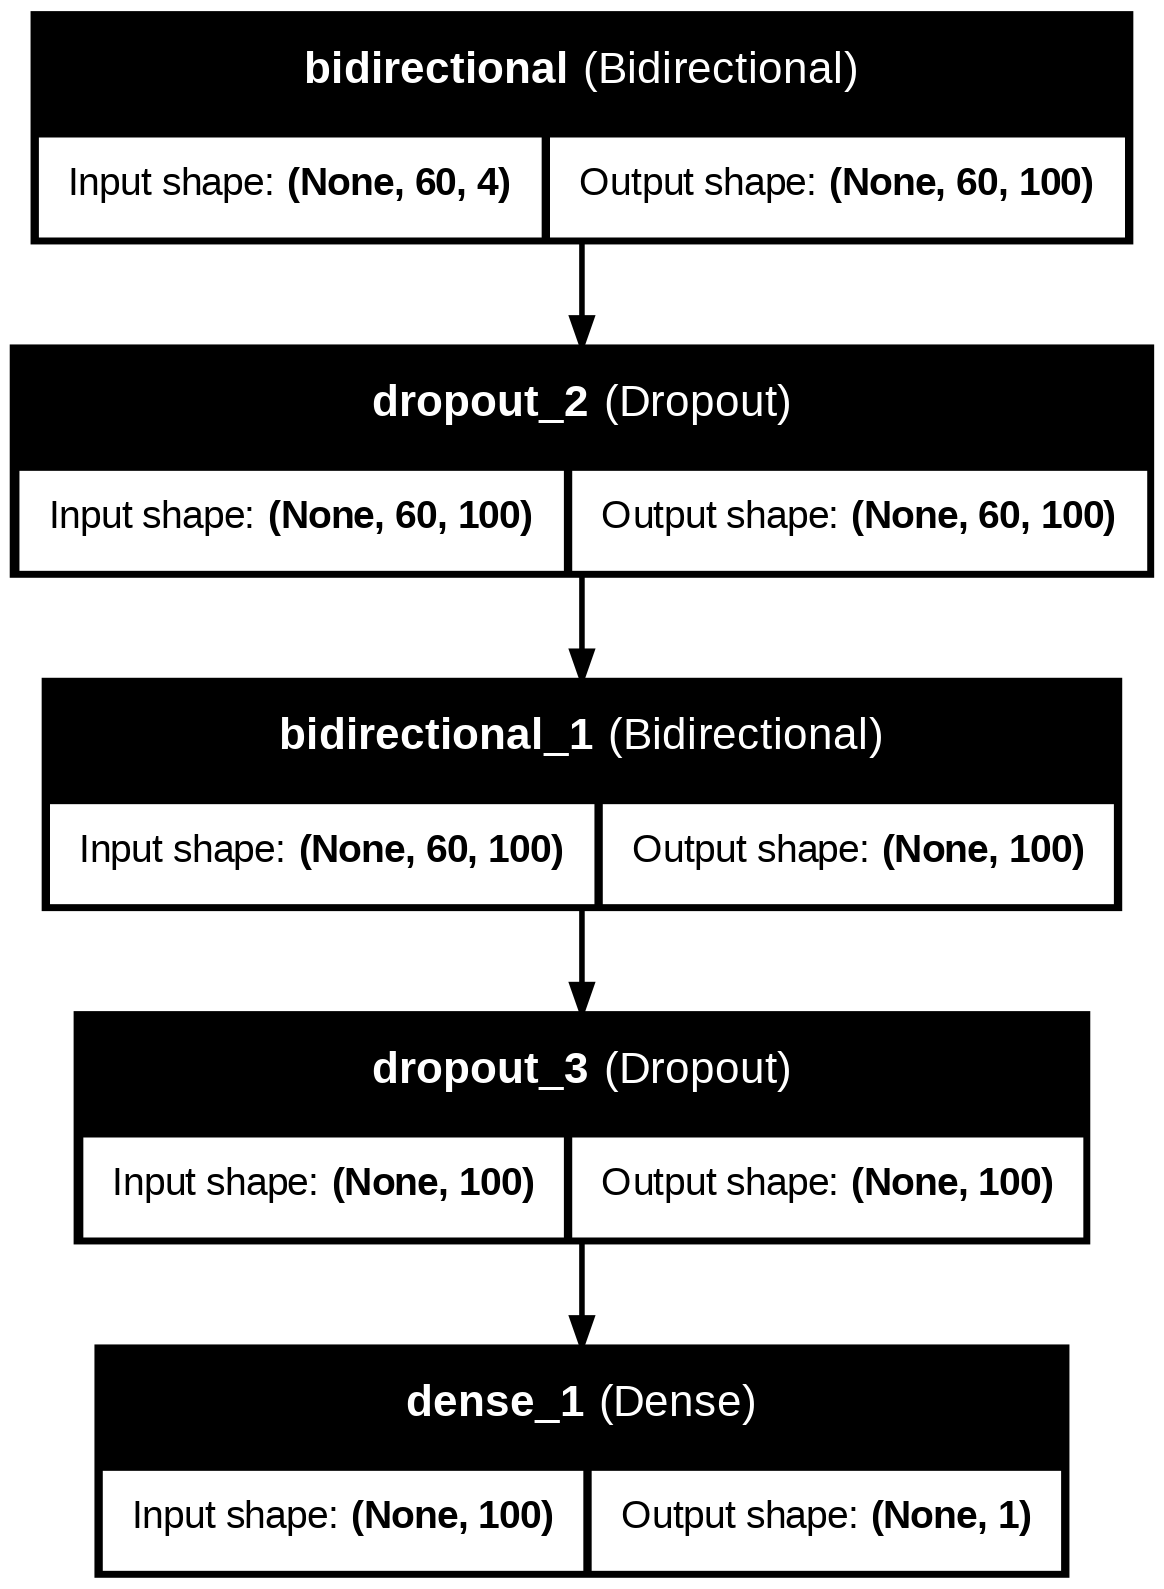

In [42]:
from tensorflow.keras.utils import plot_model

# Generate the plot and save it to a file
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the plot inline (if using a Jupyter notebook)
from IPython.display import Image
Image(filename='model_architecture.png')




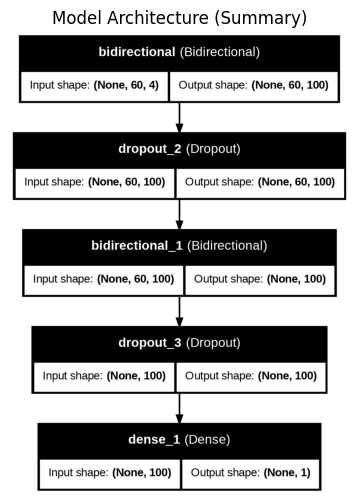

In [43]:
## If you are not using a Jupyter notebook, you can display the plot using matplotlib



img = plt.imread('model_architecture.png')
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Model Architecture (Summary)')
plt.show()

## s(ii) Compile_Train

In [44]:
# Train the model

history = model.fit(X_seq, Y_seq, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - loss: 0.0122 - val_loss: 9.2916e-04
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - loss: 0.0014 - val_loss: 6.6279e-04
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - loss: 9.4807e-04 - val_loss: 0.0011
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - loss: 8.5396e-04 - val_loss: 5.9292e-04
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - loss: 8.2080e-04 - val_loss: 0.0038
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - loss: 9.1544e-04 - val_loss: 0.0019
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - loss: 6.9711e-04 - val_loss: 5.8133e-04
Epoch 9/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - loss: 7.3565e-04 - val_loss: 0.0013
Epoch 10/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - loss: 7.3010e-04 - val_loss: 0.0025


# Step4: Forecaste

In [45]:
# Forecasting the next 5 days
def forecast(model, X, n_steps):
    forecasted = []
    current_step = X[-1]

    for _ in range(n_steps):
        current_step = current_step.reshape(1, time_steps, X.shape[2])
        predicted = model.predict(current_step)
        forecasted.append(predicted[0, 0])
        current_step = np.roll(current_step, -1, axis=1)
        current_step[0, -1, 0] = predicted

    return scaler_Y.inverse_transform(np.array(forecasted).reshape(-1, 1))

# Forecast the next 5 days
forecasted_prices = forecast(model, X_seq, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


<ipython-input-45-05900ea78d19>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_step[0, -1, 0] = predicted


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [46]:
# Extract the last date in the dataset
last_date = pd.to_datetime(data['Date'].iloc[-1])

# Generate the next 5 dates
next_5_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 6)]

# next_5_dates

## s(i) Next_5days

In [47]:
# Print the next 5 days' closing prices with dates


for date, price in zip(next_5_dates, forecasted_prices):
    print(f" {date.strftime('%Y-%m-%d')} : {price[0]}")

 2024-08-30 : 4185.6640625
 2024-08-31 : 4009.168212890625
 2024-09-01 : 3834.13916015625
 2024-09-02 : 3701.645751953125
 2024-09-03 : 3601.1318359375


## s(ii) plot_only5days

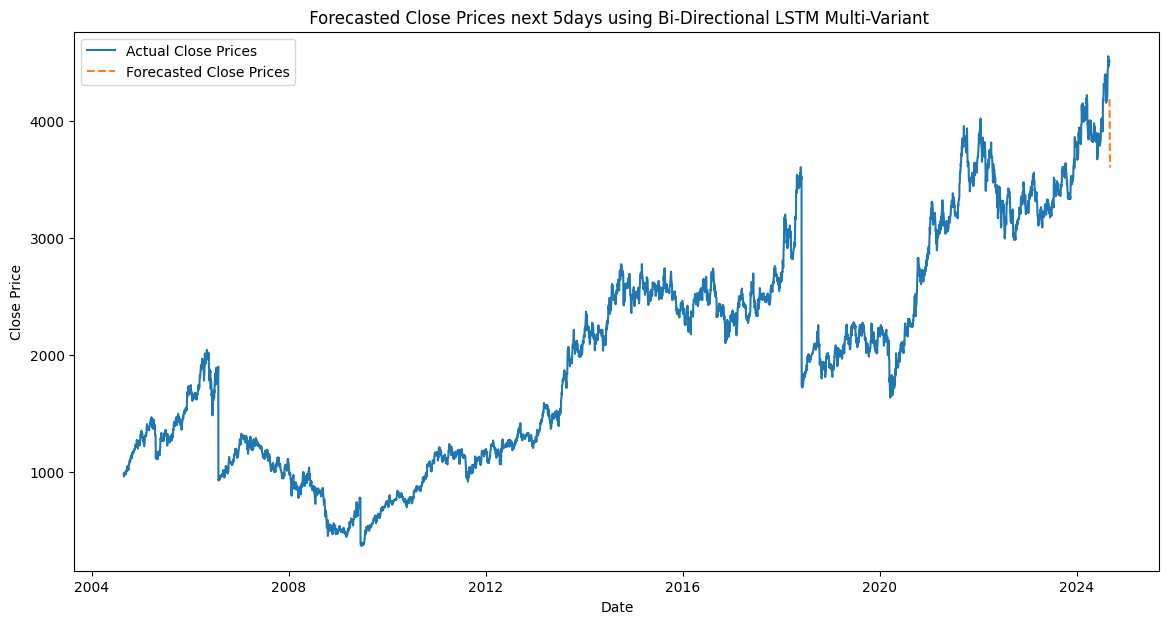

In [49]:
# Import necessary library
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the results
plt.figure(figsize=(14, 7))


# Convert 'Date' column to datetime if it's not already
if not pd.api.types.is_datetime64_any_dtype(data['Date']):
    # Use '%Y-%m-%d' format for four-digit year
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Convert dates to naive timestamps if they are timezone-aware
plt.plot(data['Date'].dt.tz_localize(None), data['Close'], label='Actual Close Prices')


# Plot forecasted closing prices
forecasted_dates = pd.to_datetime(next_5_dates)
# Convert dates to naive timestamps if they are timezone-aware
plt.plot(forecasted_dates.tz_localize(None), forecasted_prices, label='Forecasted Close Prices', linestyle='--')



plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(' Forecasted Close Prices next 5days using Bi-Directional LSTM Multi-Variant')
plt.legend()
plt.show()

## s(iii) Generate_Predication_EntireData

In [50]:
# Generate predictions for the entire dataset
predicted_prices = model.predict(X_seq)
predicted_prices = scaler_Y.inverse_transform(predicted_prices)

# Prepare data for plotting
actual_prices = scaler_Y.inverse_transform(Y_scaled[time_steps:])
dates = data['Date'][time_steps:]


154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step


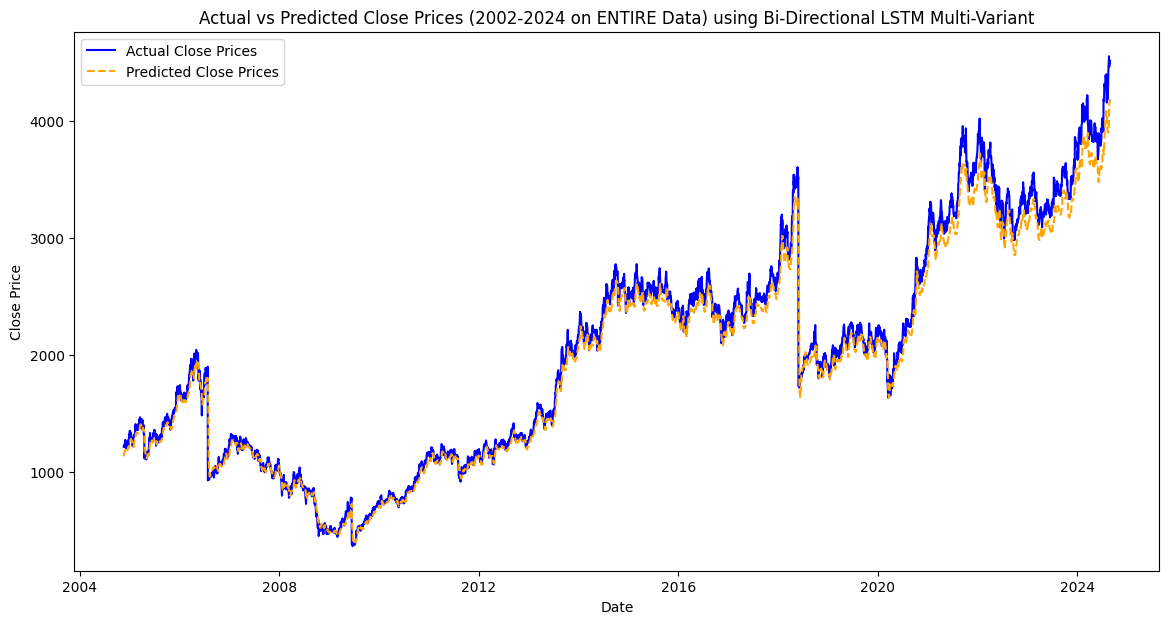

In [55]:
# Plotting the results ENTIRE dataset
plt.figure(figsize=(14, 7))

# Plot actual closing prices
plt.plot(dates, actual_prices, label='Actual Close Prices', color='blue')

# Plot forecasted closing prices
plt.plot(dates, predicted_prices, label='Predicted Close Prices', color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices (2002-2024 on ENTIRE Data) using Bi-Directional LSTM Multi-Variant')
plt.legend()
plt.show()


## s(iv) see_accuracy_RMSE

In [52]:
from sklearn.metrics import mean_squared_error, r2_score

# Use the variables you calculated previously
mse = mean_squared_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 14979.389495490628
R-squared: 0.9837480337943896


In [53]:
# Import the necessary module for regression metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'actual_prices' and 'predicted_prices' from previous calculations are your true and predicted values
y_test = actual_prices
y_pred = predicted_prices

# Calculate appropriate metrics for regression problems
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the calculated metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 14979.389495490628
Root Mean Squared Error (RMSE): 122.39031618347356
Mean Absolute Error (MAE): 89.23243961279755
R-squared (R2): 0.9837480337943896


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
